In [1]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
from torch.autograd import Variable
import os
import random
import shutil
from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F

In [2]:
global logs, best_acc
logs = []
best_acc = 0 
modellr = 1e-5
BATCH_SIZE = 8
EPOCHS = 50
number_class = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
random.seed(66)

def moveFile(input_path, rate, output_path):
    pathDir = os.listdir(input_path)
    filenumber = len(pathDir)
    picknumber = int(filenumber * rate)
    sample = random.sample(pathDir, picknumber)
    for file_name in sample:
        shutil.move(input_path +'/'+ file_name, output_path + '/' + file_name)


root = 'datasets'
categories = os.listdir(root+'/train')
np.savetxt(root+'/classes.txt', categories, fmt='%s')
for m in categories:

    input_path = root + '/train/' + str(m)
    output_path1 = root + '/val/' + str(m)
    output_path2 = root + '/test/' + str(m)

    isExists = os.path.exists(output_path1)
    if not isExists:
        os.makedirs(output_path1)
        moveFile(input_path, 0.3, output_path1)
    isExists = os.path.exists(output_path2)
    if not isExists:
        os.makedirs(output_path2)
        moveFile(output_path1, 0.3, output_path2)

In [4]:

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/255, 1/255, 1/255])])
transform_val = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/255, 1/255, 1/255])])

In [5]:

dataset_train = datasets.ImageFolder('datasets/train', transform)
dataset_val = datasets.ImageFolder('datasets/val', transform_val)
dataset_test = datasets.ImageFolder('datasets/test', transform_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# in torchvision call resnet18 pre-train model
model = torchvision.models.resnet18(pretrained=True)
#Modify the number of categories in the last classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=modellr)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    modellrnew = modellr * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = modellrnew

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    total_num = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss = loss.data.item()
        sum_loss += print_loss
        if (batch_idx + 1) % 5 == 0:
            log = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                (batch_idx + 1) * len(data),
                len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item())
            print(log)
            logs.append(log)
    ave_loss = sum_loss / len(train_loader)
    log = 'epoch:{},loss:{}'.format(epoch, ave_loss)
    print(log)
    logs.append(log)

def val(model, device, test_loader, phase):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        if phase == 'train':
            log = 'Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                avgloss,
                correct,
                len(test_loader.dataset),
                100 * acc)
        else:
            log = 'Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                avgloss,
                correct,
                len(test_loader.dataset),
                100 * acc)
            if acc > best_acc:
                best_acc = acc
                torch.save(model, 'model_best.pth')
        print(log)
        logs.append(log)
        np.savetxt('logs.txt', logs, fmt='%s')

In [8]:
start_time = time()
for epoch in range(1, EPOCHS + 1):
    adjust_learning_rate(optimizer, epoch)
    train(model, DEVICE, train_loader, optimizer, epoch)
    val(model, DEVICE, train_loader, 'train')
    val(model, DEVICE, test_loader, 'val')
torch.save(model, 'model_last.pth')
np.savetxt('logs.txt', logs, fmt='%s')
end_time = time()
print(f'training_time:{end_time-start_time}')

Train Epoch: 1 [40/2566 (2%)]	Loss: 1.318653
Train Epoch: 1 [80/2566 (3%)]	Loss: 1.210933
Train Epoch: 1 [120/2566 (5%)]	Loss: 1.194899
Train Epoch: 1 [160/2566 (6%)]	Loss: 1.134004
Train Epoch: 1 [200/2566 (8%)]	Loss: 1.396958
Train Epoch: 1 [240/2566 (9%)]	Loss: 1.193944
Train Epoch: 1 [280/2566 (11%)]	Loss: 1.088090
Train Epoch: 1 [320/2566 (12%)]	Loss: 1.133645
Train Epoch: 1 [360/2566 (14%)]	Loss: 0.872572
Train Epoch: 1 [400/2566 (16%)]	Loss: 0.939282
Train Epoch: 1 [440/2566 (17%)]	Loss: 0.567151
Train Epoch: 1 [480/2566 (19%)]	Loss: 0.787190
Train Epoch: 1 [520/2566 (20%)]	Loss: 0.890378
Train Epoch: 1 [560/2566 (22%)]	Loss: 0.909335
Train Epoch: 1 [600/2566 (23%)]	Loss: 0.650051
Train Epoch: 1 [640/2566 (25%)]	Loss: 1.374645
Train Epoch: 1 [680/2566 (26%)]	Loss: 0.635133
Train Epoch: 1 [720/2566 (28%)]	Loss: 1.356131
Train Epoch: 1 [760/2566 (30%)]	Loss: 0.695598
Train Epoch: 1 [800/2566 (31%)]	Loss: 0.787204
Train Epoch: 1 [840/2566 (33%)]	Loss: 0.732883
Train Epoch: 1 [880/2

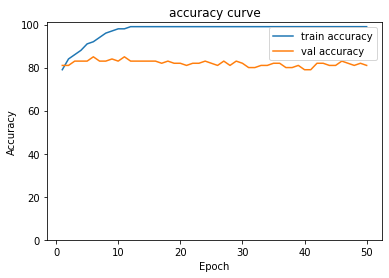

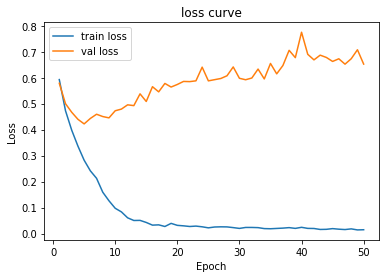

In [9]:
path = 'logs.txt'
with open(path, 'r') as f:
    lines = f.readlines()
    
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for line in lines:
    if 'Val set' in line:
        line = line.split(',')
        val_acc.append(float(line[-1].split('(')[-1].split('%')[0]))
        val_loss.append(float(line[0].split(':')[-1]))
    elif 'Train set' in line:
        line = line.split(',')
        train_acc.append(float(line[-1].split('(')[-1].split('%')[0]))
        train_loss.append(float(line[0].split(':')[-1]))
        
x = np.arange(1, len(val_acc)+1)

plt.plot(x, train_acc, label='train accuracy')
plt.legend(loc='best')
plt.plot(x, val_acc, label='val accuracy')
plt.legend(loc='best')
plt.title('accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,101)
plt.show()

plt.plot(x, train_loss, label='train loss')
plt.legend(loc='best')
plt.plot(x, val_loss, label='val loss')
plt.legend(loc='best')
plt.title('loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

准确率：0.8134556574923547
混淆矩阵: 
[[ 18  10   4   1   0]
 [ 11  66   3   2   7]
 [  1   0 161   0   0]
 [  1   8   0  15   2]
 [  0   8   0   3   6]]
每一类的precision、recall和f1-score: 
                 precision    recall  f1-score   support

          Mild
       0.58      0.55      0.56        33
      Moderate
       0.72      0.74      0.73        89
         No_DR
       0.96      0.99      0.98       162
Proliferate_DR
       0.71      0.58      0.64        26
        Severe
       0.40      0.35      0.38        17

       accuracy                           0.81       327
      macro avg       0.67      0.64      0.66       327
   weighted avg       0.81      0.81      0.81       327



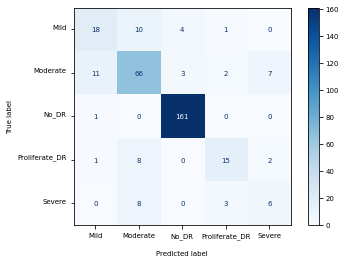

In [10]:
# 测试
with open('datasets/classes.txt', 'r') as f:
    classesname = tuple(f.readlines())
model = torch.load('model_last.pth', map_location=DEVICE.type)
model.to(DEVICE)
model.eval()
correct = 0
total_num = len(test_loader.dataset)
labels = []
preds = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = Variable(data).to(DEVICE), Variable(target).to(DEVICE)
        output = model(data)
        _, pred = torch.max(output.data, 1)
        labels.append(target.view(-1))
        preds.append(pred.view(-1))
        correct += torch.sum(pred == target)
    correct = correct.data.item()
    acc = correct / total_num
    print('Accuracy：{}'.format(acc))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    if 'cuda' in DEVICE.type:
        preds = np.array(preds.cpu())
        labels = np.array(labels.cpu())
    cm = confusion_matrix(labels, preds)

    print("confusion_matrix: ")
    print(cm)
    print("For each category:precision、recall和f1-score: ")
    print(classification_report(labels, preds, target_names=classesname))

    plt.rcParams.update({'font.size': 7})
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesname)
    disp.plot(cmap='Blues')
    plt.show()